Init train dataset with 3875 PNEUMONIA images and 1341 NORMAL images.
Init test dataset with 390 PNEUMONIA images and 234 NORMAL images.


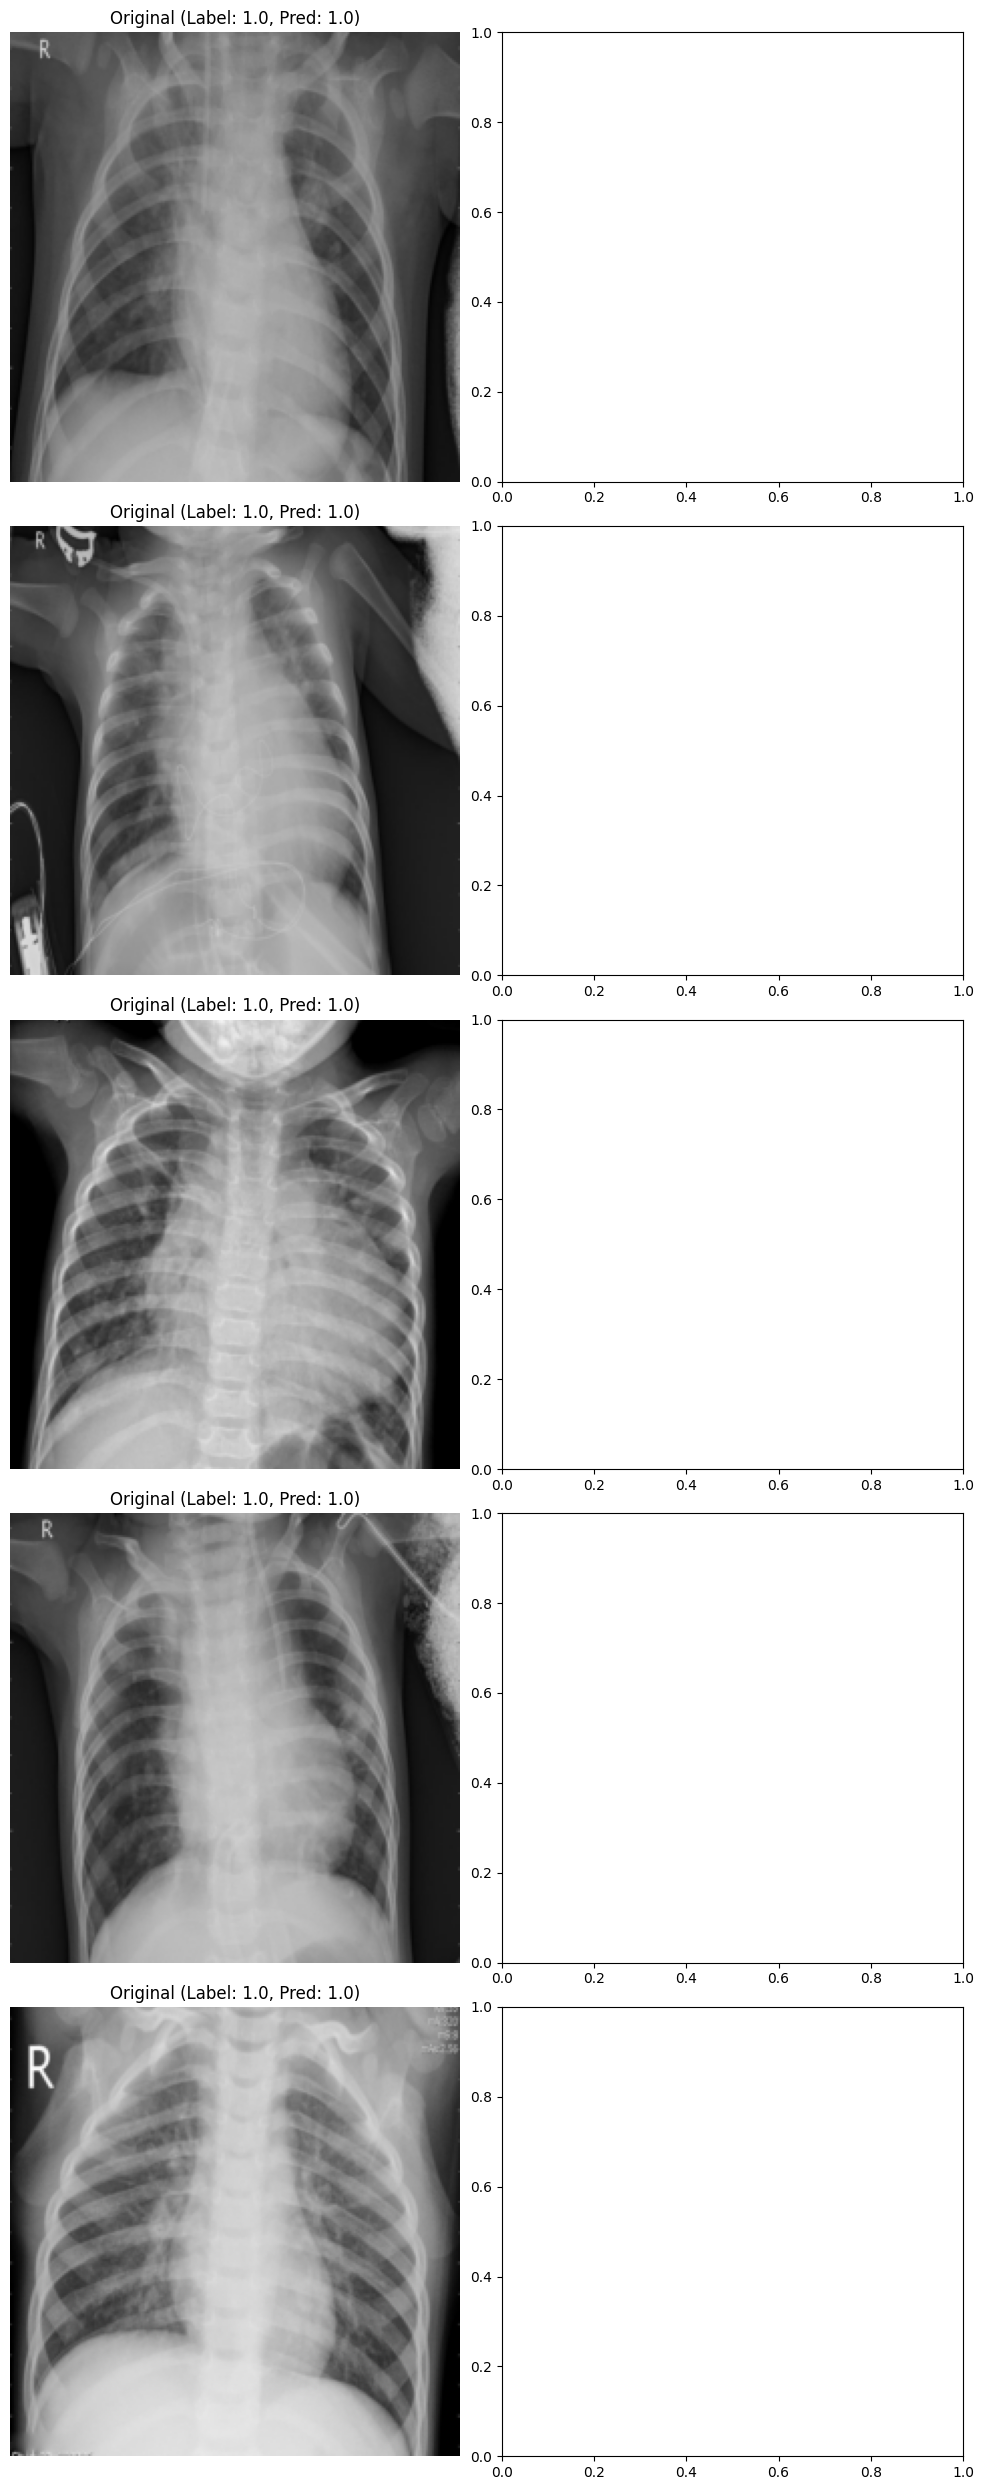

In [12]:
import datamodule
import models
import saliency
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import BaseConfig
import torch

reload(datamodule)
reload(models)
reload(saliency)

PATH_TO_CKPT = "/home/brimax/repos/medimg-saliency-benchmark/medimg-saliency-benchmark/checkpoints/rn_True_False_0.05.ckpt"
ALPHA = 0.3
N = 5  # Number of images to sample
device = "cuda" if torch.cuda.is_available() else "cpu"

def overlay_gradcam_on_image(img_tensor, cam, alpha=0.5):
    # img_tensor: shape [1, 3, H, W] (unnormalized, float [0,1])
    img_np = img_tensor.squeeze(0).detach().cpu().numpy()  # [3, H, W]
    img_np = np.transpose(img_np, (1, 2, 0))      # [H, W, 3]
    img_np = (img_np * 255).astype(np.uint8)

    # Resize cam to match image size
    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Blend heatmap with original image
    overlay = cv2.addWeighted(img_np, 1 - alpha, heatmap, alpha, 0)
    return overlay

config = BaseConfig("./config.json")
dm = datamodule.Datamodule(config)
dm.setup()
dl = dm.test_dataloader()

# Sample N random indices
indices = np.random.choice(len(dm.test_ds), N, replace=False)
indices = np.arange(390, 390+N)
# Fetch the corresponding batch of images
images = []
labels = []
for idx in indices:
    X, y = dm.test_ds[idx]
    images.append(X)
    labels.append(y)

# Convert lists to tensors
X = torch.stack(images).to(device)
y = torch.tensor(labels).to(device)

model = models.BaseCNN.load_from_checkpoint(PATH_TO_CKPT).to(device)
model.eval()
pred = model.predict(X)

# gcam = saliency.GradCAM(model.model)
# cams = []
# model.to(device)
# gcam = saliency.GradCAM(model.model)
# for i in range(N):
#     single_cam = gcam(X[[i]])  # Add batch dimension with X[[i]]
#     cams.append(single_cam)
# Plotting
fig, axes = plt.subplots(N, 2, figsize=(10, 5*N))  # Adjust figure size as needed

for i in range(N):
    # Original Image
    img = X[i].permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Original (Label: {y[i].item()}, Pred: {pred[i].item()})")

    # GradCAM Overlay
    # overlay = overlay_gradcam_on_image(X[i:i+1], cams[i], alpha=ALPHA)
    # axes[i, 1].imshow(overlay)
    # axes[i, 1].axis('off')
    # axes[i, 1].set_title(f"GradCAM (Pred: {pred[i].item()})")

plt.tight_layout()
plt.show()

In [3]:
# Parse the results to write in a nice latex table
import json
import os

# Parse the JSON file
def parse_json_and_format_for_latex(json_data):
    # Load the JSON data
    data = json_data
    
    # Extract the results
    results = data["results"][0]
    
    # Format the metrics with confidence intervals
    # We'll round to 3 decimal places and format as "mean ± half_width"
    metrics = {}
    
    # Calculate and format each metric
    metrics["accuracy"] = f"{results['test/accuracy_mean']:.3f} $\\pm$ {(results['test/accuracy_ci_upper'] - results['test/accuracy_ci_lower'])/2:.3f}"
    metrics["precision"] = f"{results['test/precision_mean']:.3f} $\\pm$ {(results['test/precision_ci_upper'] - results['test/precision_ci_lower'])/2:.3f}"
    metrics["recall"] = f"{results['test/recall_mean']:.3f} $\\pm$ {(results['test/recall_ci_upper'] - results['test/recall_ci_lower'])/2:.3f}"
    metrics["auroc"] = f"{results['test/auroc_mean']:.3f} $\\pm$ {(results['test/auroc_ci_upper'] - results['test/auroc_ci_lower'])/2:.3f}"
    
    # Print the formatted metrics for LaTeX table
    print("Formatted metrics for LaTeX table:")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"ROC AUC: {metrics['auroc']}")
    
    # Return the metrics dictionary
    return metrics

for evals in os.listdir("evaluation"):
    print()
    print(evals.split("_")[:3])
    with open(f"evaluation/{evals}", "r") as f:
        res = json.load(f)
    metrics = parse_json_and_format_for_latex(res)

    print(f"YourModel & {metrics['accuracy']} & {metrics['precision']} & {metrics['recall']} & {metrics['auroc']}\\\\")


['an', 'True', 'False']
Formatted metrics for LaTeX table:
Accuracy: 0.761 $\pm$ 0.011
Precision: 0.728 $\pm$ 0.012
Recall: 0.985 $\pm$ 0.004
ROC AUC: 0.832 $\pm$ 0.011
YourModel & 0.761 $\pm$ 0.011 & 0.728 $\pm$ 0.012 & 0.985 $\pm$ 0.004 & 0.832 $\pm$ 0.011\\

['an', 'True', 'True']
Formatted metrics for LaTeX table:
Accuracy: 0.734 $\pm$ 0.024
Precision: 0.703 $\pm$ 0.027
Recall: 0.995 $\pm$ 0.005
ROC AUC: 0.860 $\pm$ 0.021
YourModel & 0.734 $\pm$ 0.024 & 0.703 $\pm$ 0.027 & 0.995 $\pm$ 0.005 & 0.860 $\pm$ 0.021\\

['in', 'True', 'False']
Formatted metrics for LaTeX table:
Accuracy: 0.744 $\pm$ 0.013
Precision: 0.712 $\pm$ 0.015
Recall: 0.993 $\pm$ 0.003
ROC AUC: 0.808 $\pm$ 0.014
YourModel & 0.744 $\pm$ 0.013 & 0.712 $\pm$ 0.015 & 0.993 $\pm$ 0.003 & 0.808 $\pm$ 0.014\\

['an', 'False', 'False']
Formatted metrics for LaTeX table:
Accuracy: 0.726 $\pm$ 0.018
Precision: 0.698 $\pm$ 0.019
Recall: 0.990 $\pm$ 0.005
ROC AUC: 0.774 $\pm$ 0.018
YourModel & 0.726 $\pm$ 0.018 & 0.698 $\pm$ 